# **뉴스 카테고리 다중분류 프로젝트**

## 순서
- 평가기준
- 필요한 라이브러리 불러오기
- 데이터 불러오기 및 탐색
- 텍스트 데이터로 변환 후 벡터화하기
- 머신러닝 모델 성능비교
- 딥러닝 모델 성능비교

# 평가 기준

1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?
  - 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.
2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?
  - Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.
3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?
  - 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.

# 필요한 라이브러리 불러오기
---
- 데이터를 불러오는 것부터 성능평가까지 필요한 라이브러리를 불러온다.

In [1]:
# 데이터 로드 라이브러리
from tensorflow.keras.datasets import reuters

# 기본적인 시각화와 전처리 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 단어 벡터화
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 머신러닝 모델
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from joblib import Parallel, delayed  # 병렬 처리용 라이브러리

# 모델 평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 데이터 불러오기 및 탐색
- reuter 뉴스 데이터를 사용한다. 해당 데이터는 46개의 클래스(주제)로 구성되며, 해당 뉴스가 어느 카테고리에 속하는지를 예측하기 위한 데이터이다.

- **3가지 데이터셋**을 사용하여 성능을 비교하려고 한다.
  1. 모든 단어 사용
  2. 빈도수 상위 50% 단어 사용
  3. 빈도수 상위 5000개 단어 사용

- 데이터를 불러올 때, 80%를 훈련데이터, 20%를 테스트 데이터로 사용하려고 한다.

In [2]:
# 데이터 불러오기 - 모든 단어를 사용
(x_train_all, y_train_all), (x_test_all, y_test_all) = reuters.load_data(num_words=None,
                                                                         test_split=0.2)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


- 단어 빈도수가 상위 50%이상인 단어의 개수를 확인하기 위해 단어인덱스를 불러온다.

In [3]:
# 단어 인덱스의 개수 확인
word_index = reuters.get_word_index(path="reuters_word_index.json")
print(f'단어인덱스의 길이: {len(word_index)}')

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
단어인덱스의 길이: 30979


In [4]:
# 데이터 불러오기 - 빈도수 상위 50%단어 사용

# 사용할 단어 인덱스 개수
words_50p = int(len(word_index)/2)
print(f'사용할 단어 수: {words_50p}')

(x_train_50p, y_train_50p), (x_test_50p, y_test_50p) = reuters.load_data(num_words=words_50p,
                                                                         test_split=0.2)

사용할 단어 수: 15489


In [5]:
# 데이터 불러오기 - 빈도수 상위 5000개 단어 사용
(x_train_5t, y_train_5t), (x_test_5t, y_test_5t) = reuters.load_data(num_words=5000,
                                                                    test_split=0.2)

- 샘플 수를 출력해본다. 모든 데이터셋의 훈련 데이터와 테스트데이터의 개수는 같으므로, 모든 단어를 불러온 데이터셋에 대해서만 출력했다.

In [6]:
# 샘플 수
print('훈련 샘플의 수: {}'.format(len(x_train_all)))
print('테스트 샘플의 수: {}'.format(len(x_test_all)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


## 데이터의 분포 확인해보기
---
- 불러온 데이터(뉴스)의 길이의 분포를 확인해본다.
- 위와 마찬가지로 모든 데이터셋의 크기는 같으므로, `x_train_all`, `y_train_all`에 대해서만 확인해본다.

뉴스텍스트(훈련)의 최대 길이 :2376
뉴스텍스트(훈련)의 중간 길이 :95.0
뉴스텍스트(훈련)의 평균 길이 :145.5398574927633


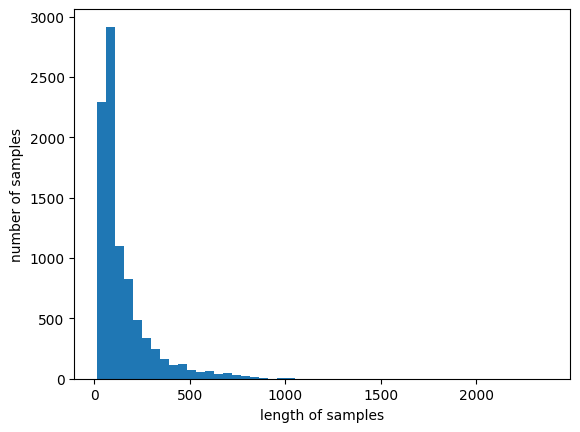

In [7]:
# 뉴스 데이터의 길이 분포
print('뉴스텍스트(훈련)의 최대 길이 :{}'.format(max(len(l) for l in x_train_all)))
print('뉴스텍스트(훈련)의 중간 길이 :{}'.format(np.median([len(l) for l in x_train_all])))
print('뉴스텍스트(훈련)의 평균 길이 :{}'.format(sum(map(len, x_train_all))/len(x_train_all)))

plt.hist([len(s) for s in x_train_all], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 훈련데이터의 분포가 right-skew된 형태를 가진다.
  - 길이가 짧은 데이터에 대해서는 주제에 대한 단서를 얻기 어려울 수 있지 않을까?
  - 긴 텍스트의 길이를 가진 데이터들로 인해 희소행렬이 발생하면서 모델 성능의 저하가 오지 않을까?

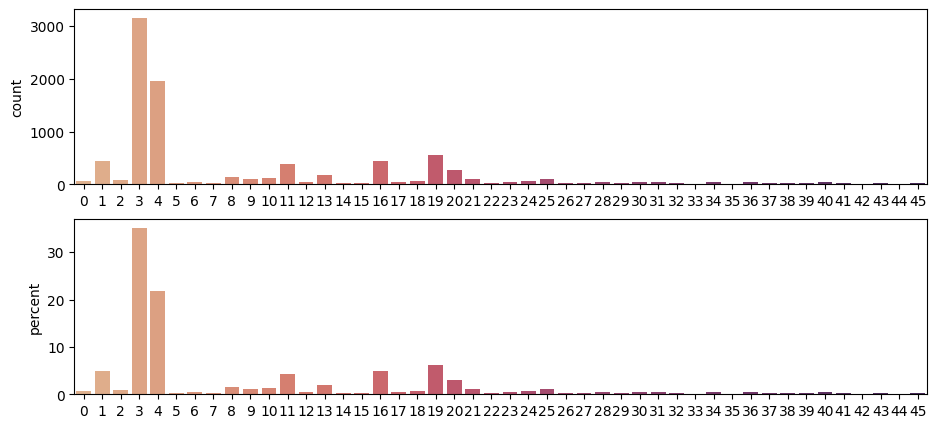

In [8]:
# 클래스의 분포를 확인
fig, axe = plt.subplots(2, 1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train_all, palette="flare", hue=y_train_all, legend=False, ax=axe[0])
sns.countplot(x=y_train_all, palette="flare", hue=y_train_all, legend=False, ax=axe[1], stat = 'percent')
plt.show()

In [9]:
# 각 클래스의 빈도수를 표로 나타내기
unique_elements, counts_elements = np.unique(y_train_all, return_counts=True)
print("각 클래스 빈도수:")
pd.set_option("display.max_columns", 50)
pd.DataFrame([np.round(counts_elements/sum(counts_elements), 4)],
             columns = unique_elements)

각 클래스 빈도수:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
0,0.0061,0.0481,0.0082,0.3517,0.217,0.0019,0.0053,0.0018,0.0155,0.0112,0.0138,0.0434,0.0055,0.0191,0.0029,0.0022,0.0494,0.0043,0.0073,0.0611,0.0299,0.0111,0.0017,0.0046,0.0069,0.0102,0.0027,0.0017,0.0053,0.0021,0.005,0.0043,0.0036,0.0012,0.0056,0.0011,0.0055,0.0021,0.0021,0.0027,0.004,0.0033,0.0014,0.0023,0.0013,0.002


- 클래스의 불균형이 심함을 알 수 있다.
  - 주로 3번과 4번에 많이 몰려있고 두 개의 클래스를 합하면 전체에서 반 이상의 데이터가 해당 클래스의 몰려있음을 알 수 있다.

# 텍스트 데이터로 변환 후 벡터화하기
---
- 해당 데이터는 각 단어를 정수 시퀀스로 변환된 채 제공함.
- 텍스트데이터에 대해 벡터화를 시키기위해 정수로 변환된 데이터를 텍스트로 변환
- 텍스트로 변환 후 다시 TF-IDF행렬로 벡터화를 진행

## 단어 인덱스 불러오기 및 수정

In [10]:
# 단어 인덱스 불러오기
word_index = reuters.get_word_index(path='reuters_word_index.json')

# 앞에 위치한 10개의 데이터만 확인
list(word_index.items())[:10]

[('mdbl', 10996),
 ('fawc', 16260),
 ('degussa', 12089),
 ('woods', 8803),
 ('hanging', 13796),
 ('localized', 20672),
 ('sation', 20673),
 ('chanthaburi', 20675),
 ('refunding', 10997),
 ('hermann', 8804)]

- 텍스트 데이터를 숫자 인덱스로 변환할 때, 일반적으로 예약된 인덱스가 포함된다.
- 실제 단어에는 나타나지 않지만, 해당 데이터에서는 0,1,2번에 각각
  - `<pad>`: 패딩 토큰
  - `<sos>`: 문서시작 토큰
  - `<unk>`: 인식하지 못하는 단어에 대한 토큰
  가 저장되어 있다.
- 따라서 이를 보정하기 위해, 정수를 인덱스로 바꿀 때 `i-3`사용하기로 한다.

In [11]:
# 정수: 단어 형태로 변경
index_to_word = {index+3 : word for word, index in word_index.items() }

list(sorted(index_to_word.items()))[:5]

[(4, 'the'), (5, 'of'), (6, 'to'), (7, 'in'), (8, 'said')]

- 딕셔너리 데이터에서 키값이 0,1,2를 가지는 데이터에 대해 예약된 인덱스를 포함해준다.

In [12]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줌
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

list(sorted(index_to_word.items()))[:4]

[(0, '<pad>'), (1, '<sos>'), (2, '<unk>'), (4, 'the')]

## 뉴스 데이터를 텍스트 데이터로 변환
- 위에서 만든 `index_to_word`를 이용해, 정수 시퀀스로 저장된 뉴스 데이터를 텍스트 데이터로 변환해준다.

In [13]:
# 텍스트 데이터로 변환하는 함수 정의
def int_to_text(data, words = index_to_word):
  decoded = []
  for i in range(len(data)):
    t = ' '.join([words[index] for index in data[i]])
    decoded.append(t)

  data = decoded
  print(f'변환된 텍스트의 개수: {len(data)}')
  print(f'첫번째 데이터: {data[0]}\n\n')

  return data

### 모든 단어를 사용한 데이터셋

In [14]:
# 텍스트 데이터 변환 - 모든 단어를 사용한 데이터셋
x_train_all_to_text = int_to_text(x_train_all)
x_test_all_to_text = int_to_text(x_test_all)

변환된 텍스트의 개수: 8982
첫번째 데이터: <sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


변환된 텍스트의 개수: 2246
첫번째 데이터: <sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct

### 빈도수 상위 50%의 단어를 사용한 데이터셋

In [15]:
# 텍스트 데이터 변환 - 빈도수 상위 50%의 단어를 사용한 데이터셋
x_train_50p_to_text = int_to_text(x_train_50p)
x_test_50p_to_text = int_to_text(x_test_50p)

변환된 텍스트의 개수: 8982
첫번째 데이터: <sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


변환된 텍스트의 개수: 2246
첫번째 데이터: <sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a

### 5000개의 단어를 사용한 데이터셋

In [16]:
# 텍스트 데이터 변환 - 5000개의 단어를 사용한 데이터셋
x_train_5t_to_text = int_to_text(x_train_5t)
x_test_5t_to_text = int_to_text(x_test_5t)

변환된 텍스트의 개수: 8982
첫번째 데이터: <sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


변환된 텍스트의 개수: 2246
첫번째 데이터: <sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a

- 단어사용 개수가 적어질수록 `<unk>`가 차지하는 비율이 더 높아짐을 알 수 있다.

## 벡터화하기
- DTM행렬을 생성해준뒤, 그것을 기반으로 TF-IDF행렬을 만들어준다.
- 이전에 같은데이터를 다루었을 때, 불용어(stop_words=`english`)를 사용한 경우와 그렇지 않은 경우를 비교한결과 모델의 성능이 비슷하거나 불용어를 사용하지 않은 경우에 성능이 1~2%정도 높게 나왔다. 따라서 해당 뉴스 데이터를 벡터화할 때도 불용어를 사용하지 않기로 한다.

### DTM행렬 생성

In [17]:
# DTM행렬을 생성하는 함수
def make_dtm_matrix(train_data, test_data):
  dtmvector = CountVectorizer(stop_words='english')
  x_train_dtm = dtmvector.fit_transform(train_data)
  x_test_dtm = dtmvector.transform(test_data)

  print(f'훈련 데이터의 DTM차원: {x_train_dtm.shape}')
  print(f'테스트 데이터의 DTM차원: {x_test_dtm.shape}')
  print('\n')

  return x_train_dtm, x_test_dtm

In [18]:
# DTM행렬 생성

## 모든 단어를 사용한 데이터셋
x_train_all_dtm, x_test_all_dtm = make_dtm_matrix(x_train_all_to_text,
                                                  x_test_all_to_text)

## 빈도수 상위 50%의 단어를 사용한 데이터셋
x_train_50p_dtm, x_test_50p_dtm = make_dtm_matrix(x_train_50p_to_text,
                                                  x_test_50p_to_text)

## 5000개의 단어를 사용한 데이터셋
x_train_5t_dtm, x_test_5t_dtm = make_dtm_matrix(x_train_5t_to_text,
                                                  x_test_5t_to_text)

훈련 데이터의 DTM차원: (8982, 26218)
테스트 데이터의 DTM차원: (2246, 26218)


훈련 데이터의 DTM차원: (8982, 14384)
테스트 데이터의 DTM차원: (2246, 14384)


훈련 데이터의 DTM차원: (8982, 4633)
테스트 데이터의 DTM차원: (2246, 4633)




- 각각 데이터셋에서 행은 데이터의 개수가 나옴을 알 수 있다.
- 열은 각 데이터셋마다 불러온 단어의 개수로 채워질 것으로 예상했으나 모든 데이터셋에서 단어의 개수보다 약간 적은 개수의 컬럼이 만들어졌음을 알 수 있다.

### TF-IDF행렬 생성
- 위에서 만든 DTM행렬을 이용해 TF-IDF행렬을 생성한다.

In [19]:
# TF-IDF행렬을 생성하는 함수
def dtm_to_tfidf(train_dtm, test_dtm):
  tfidf_transformer = TfidfTransformer()
  x_train_tfidf = tfidf_transformer.fit_transform(train_dtm)
  x_test_tfidf = tfidf_transformer.transform(test_dtm)
  print(f'훈련 데이터의 TF-IDF차원: {x_train_tfidf.shape}')
  print(f'테스트 데이터의 TF-IDF차원: {x_test_tfidf.shape}')
  print('\n')

  return x_train_tfidf, x_test_tfidf

In [20]:
# TF-IDF행렬을 생성

## 모든 단어를 사용한 데이터셋
x_train_all_tfidf, x_test_all_tfidf = dtm_to_tfidf(x_train_all_dtm,
                                                      x_test_all_dtm)

## 빈도수 상위 50%의 단어를 사용한 데이터셋
x_train_50p_tfidf, x_test_50p_tfidf = dtm_to_tfidf(x_train_50p_dtm,
                                                  x_test_50p_dtm)

## 5000개의 단어를 사용한 데이터셋
x_train_5t_tfidf, x_test_5t_tfidf = dtm_to_tfidf(x_train_5t_dtm,
                                                  x_test_5t_dtm)

훈련 데이터의 TF-IDF차원: (8982, 26218)
테스트 데이터의 TF-IDF차원: (2246, 26218)


훈련 데이터의 TF-IDF차원: (8982, 14384)
테스트 데이터의 TF-IDF차원: (2246, 14384)


훈련 데이터의 TF-IDF차원: (8982, 4633)
테스트 데이터의 TF-IDF차원: (2246, 4633)




# 머신러닝 모델 성능 비교
---
- 사용할 모델: 나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤 포레스트, 그래디언트 부스팅 트리, 보팅
- 재현 가능한 결과를 위해 `random_state`를 사용해준다. (`numpy`의 `random.seed()`를 사용하는 등 한 번에 할 수 있으나 작동하지 않는 경우를 대비해 일일이 설정해준다.)
- Accuracy, f1-score 비교
- 성능이 가장 잘 나온 3가지 모델을 선정하여 보팅해주어 결과를 다시 비교해본다.

In [21]:
## 사용할 모델 불러오기 ##

# 나이브 베이즈 분류기(Multinomial Naive Bayes)
mnb = MultinomialNB()

# CNB: Complement Naive Bayes
cnb = ComplementNB()

# 로지스틱 회귀(LogisticRegression)
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)

# 서포트 벡터 머신(Support Vector Machine)
l_svc = LinearSVC(random_state = 42, C=1000, penalty='l2', max_iter=3000, dual=False)
nl_svc = SVC(random_state = 42, kernel='sigmoid', max_iter=3000, probability=True)

# 결정 트리(DecisionTree)
dt = DecisionTreeClassifier(max_depth=47, random_state=42)

# 랜덤 포레스트(RandomForest)
rf = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=47)

# 그래디언트 부스팅 트리(Gradient Boosting)
gbt = GradientBoostingClassifier(random_state = 42)

# 확률적 경사하강법(Stochastic Gradient Descent)
sgd = SGDClassifier(random_state=42)

# 모델을 리스트에 저장
models = [mnb, cnb, lr, l_svc, nl_svc, dt, rf, gbt, sgd]

In [38]:
### 모델별 성능을 구하기 위한 함수 ###
import time

# 단일 모델 성능 계산
def get_model_predict(model, x_tr, y_tr, x_te, y_te):
  start_time = time.time()  # 시작 시간 기록
  model.fit(x_tr, y_tr)
  pred = model.predict(x_te)
  end_time = time.time()  # 종료 시간 기록

  accuracy = accuracy_score(y_te, pred)
  f1_ = f1_score(y_te, pred, average='weighted')
  elapsed_time = end_time - start_time  # 실행 시간 계산

  print('### Complete ', model.__class__.__name__, ' ###')
#   print(f'정확도: {accuracy:.4f}, f1-score:{f1_:.4f}, Time: {elapsed_time:.4f}')
  return model.__class__.__name__, accuracy, f1_, elapsed_time


# 모델별 평가 함수
def evaluate_models(models, x_tr, y_tr, x_te, y_te):
  model_evals = {}
  for model in models:
    model_name, acc, f1, elapsed_time = get_model_predict(model,
                                                          x_tr, y_tr, x_te, y_te)
    model_evals[model_name] = {
        "accuracy": np.round(acc, 4),
        "f1" : np.round(f1, 4),
        "time": np.round(elapsed_time, 4)
    }

  return model_evals

# 결과 출력 함수
def display_results(results):
  for model_name, metrics, in results.items():
    print(f"### {model_name} ###")
    print('Accuracy: ', metrics['accuracy'])
    print('F1 Score: ', metrics['f1'])
    print('Time: ', metrics['time'], '\n')


## 모든 단어를 사용한 데이터셋

In [23]:
print('모든 단어를 사용한 데이터셋: \n')

# 모델별 평가 수행
eval_all_results = evaluate_models(models,
                                   x_train_all_tfidf,
                                   y_train_all,
                                   x_test_all_tfidf,
                                   y_test_all)

모든 단어를 사용한 데이터셋: 

### Complete  MultinomialNB  ###
### Complete  ComplementNB  ###
### Complete  LogisticRegression  ###
### Complete  LinearSVC  ###
### Complete  SVC  ###
### Complete  DecisionTreeClassifier  ###
### Complete  RandomForestClassifier  ###
### Complete  GradientBoostingClassifier  ###
### Complete  SGDClassifier  ###


In [24]:
# 결과 출력
display_results(eval_all_results)

### MultinomialNB ###
Accuracy:  {0.6487}
F1 Score:  {0.5601}
Time:  {0.1574}  seconds

### ComplementNB ###
Accuracy:  {0.772}
F1 Score:  {0.7429}
Time:  {0.1177}  seconds

### LogisticRegression ###
Accuracy:  {0.8121}
F1 Score:  {0.8056}
Time:  {39.8101}  seconds

### LinearSVC ###
Accuracy:  {0.8054}
F1 Score:  {0.8019}
Time:  {23.5611}  seconds

### SVC ###
Accuracy:  {0.8272}
F1 Score:  {0.8174}
Time:  {328.9497}  seconds

### DecisionTreeClassifier ###
Accuracy:  {0.7057}
F1 Score:  {0.6977}
Time:  {6.6607}  seconds

### RandomForestClassifier ###
Accuracy:  {0.7582}
F1 Score:  {0.7312}
Time:  {313.777}  seconds

### GradientBoostingClassifier ###
Accuracy:  {0.7769}
F1 Score:  {0.7729}
Time:  {1316.8746}  seconds

### SGDClassifier ###
Accuracy:  {0.8419}
F1 Score:  {0.8343}
Time:  {1.9424}  seconds



## 빈도수 상위 50% 단어를 사용한 데이터셋

In [25]:
print('빈도수 상위 50% 단어를 사용한 데이터셋: \n')

# 모델별 평가 수행
eval_50p_results = evaluate_models(models,
                                   x_train_50p_tfidf,
                                   y_train_50p,
                                   x_test_50p_tfidf,
                                   y_test_50p)

빈도수 상위 50% 단어를 사용한 데이터셋: 

### Complete  MultinomialNB  ###
### Complete  ComplementNB  ###
### Complete  LogisticRegression  ###
### Complete  LinearSVC  ###
### Complete  SVC  ###
### Complete  DecisionTreeClassifier  ###
### Complete  RandomForestClassifier  ###
### Complete  GradientBoostingClassifier  ###
### Complete  SGDClassifier  ###


In [26]:
# 결과 출력
display_results(eval_50p_results)

### MultinomialNB ###
Accuracy:  {0.6705}
F1 Score:  {0.5894}
Time:  {0.076}  seconds

### ComplementNB ###
Accuracy:  {0.7792}
F1 Score:  {0.7546}
Time:  {0.07}  seconds

### LogisticRegression ###
Accuracy:  {0.8112}
F1 Score:  {0.8048}
Time:  {25.078}  seconds

### LinearSVC ###
Accuracy:  {0.8028}
F1 Score:  {0.7993}
Time:  {22.4031}  seconds

### SVC ###
Accuracy:  {0.8259}
F1 Score:  {0.8161}
Time:  {303.3708}  seconds

### DecisionTreeClassifier ###
Accuracy:  {0.6986}
F1 Score:  {0.6912}
Time:  {7.0647}  seconds

### RandomForestClassifier ###
Accuracy:  {0.7649}
F1 Score:  {0.7415}
Time:  {222.8991}  seconds

### GradientBoostingClassifier ###
Accuracy:  {0.7698}
F1 Score:  {0.7693}
Time:  {1217.395}  seconds

### SGDClassifier ###
Accuracy:  {0.8424}
F1 Score:  {0.8357}
Time:  {1.0688}  seconds



## 5000개의 단어를 사용한 데이터셋

In [27]:
print('5000개의 단어를 사용한 데이터셋: \n')

# 모델별 평가 수행
eval_5t_results = evaluate_models(models,
                                x_train_5t_tfidf,
                                y_train_5t,
                                x_test_5t_tfidf,
                                y_test_5t)


5000개의 단어를 사용한 데이터셋: 

### Complete  MultinomialNB  ###
### Complete  ComplementNB  ###
### Complete  LogisticRegression  ###
### Complete  LinearSVC  ###
### Complete  SVC  ###
### Complete  DecisionTreeClassifier  ###
### Complete  RandomForestClassifier  ###
### Complete  GradientBoostingClassifier  ###
### Complete  SGDClassifier  ###


In [28]:
# 결과 출력
display_results(eval_5t_results)

### MultinomialNB ###
Accuracy:  {0.7026}
F1 Score:  {0.6426}
Time:  {0.0526}  seconds

### ComplementNB ###
Accuracy:  {0.7801}
F1 Score:  {0.756}
Time:  {0.0272}  seconds

### LogisticRegression ###
Accuracy:  {0.8063}
F1 Score:  {0.8008}
Time:  {19.5066}  seconds

### LinearSVC ###
Accuracy:  {0.7939}
F1 Score:  {0.7903}
Time:  {11.6051}  seconds

### SVC ###
Accuracy:  {0.8255}
F1 Score:  {0.8157}
Time:  {218.8}  seconds

### DecisionTreeClassifier ###
Accuracy:  {0.7044}
F1 Score:  {0.6958}
Time:  {4.7158}  seconds

### RandomForestClassifier ###
Accuracy:  {0.776}
F1 Score:  {0.7557}
Time:  {136.123}  seconds

### GradientBoostingClassifier ###
Accuracy:  {0.7631}
F1 Score:  {0.7621}
Time:  {1058.0136}  seconds

### SGDClassifier ###
Accuracy:  {0.8419}
F1 Score:  {0.8355}
Time:  {0.7771}  seconds



## 보팅(Voting)
---
- 가장 성능이 좋은 데이터셋
- 가장 성능이 좋은 모델 3가지를 이용하여 보팅 - 소프트보팅, 하드보팅

In [29]:
# 보팅 - 소프트보팅
from sklearn.calibration import CalibratedClassifierCV
c3v_sgd = CalibratedClassifierCV(sgd, method='sigmoid', cv=5)
voting_soft =  VotingClassifier(voting='soft',
                                estimators=[('lr',lr), ('nl_svc', nl_svc), ('c3v_sgd', c3v_sgd)],
                                n_jobs=-1)

start_time = time.time()  # 시작 시간 기록
voting_soft.fit(x_train_50p_tfidf, y_train_50p)
pred = voting_soft.predict(x_test_50p_tfidf)
end_time = time.time()  # 종료 시간 기록

accuracy = accuracy_score(y_test_50p, pred)
f1_ = f1_score(y_test_50p, pred, average='weighted')
elapsed_time = end_time - start_time  # 실행 시간 계산

print('### Complete ', voting_soft.__class__.__name__, '(soft) ###')
print(f'정확도: {accuracy:.4f}, f1-score:{f1_:.4f}, Time: {elapsed_time:.4f}')

### Complete  VotingClassifier (soft) ###
정확도: 0.8290, f1-score:0.8221, Time: 332.4682


In [31]:
# 보팅 - 하드보팅
voting_hard =  VotingClassifier(voting='hard',
                                estimators=[('lr',lr), ('nl_svc', nl_svc), ('sgd', sgd)],
                                n_jobs=-1)

start_time = time.time()  # 시작 시간 기록
voting_hard.fit(x_train_50p_tfidf, y_train_50p)
pred = voting_hard.predict(x_test_50p_tfidf)
end_time = time.time()  # 종료 시간 기록

accuracy = accuracy_score(y_test_50p, pred)
f1_ = f1_score(y_test_50p, pred, average='weighted')
elapsed_time = end_time - start_time  # 실행 시간 계산

print('### Complete ', voting_hard.__class__.__name__, '() ###')
print(f'정확도: {accuracy:.4f}, f1-score:{f1_:.4f}, Time: {elapsed_time:.4f}')

### Complete  VotingClassifier () ###
정확도: 0.8317, f1-score:0.8225, Time: 313.6942


In [32]:
# 보팅 - 하드보팅
voting_hard2 =  VotingClassifier(voting='hard',
                                estimators=[('mnb', mnb), ('lr', lr),
                                 ('cnb', cnb), ('l_svc', l_svc), ('nl_svc', nl_svc),
                                            ('sgd', sgd), ('dt', dt), ('rf', rf), ('gbt', gbt) ],
                                n_jobs=-1)

start_time = time.time()  # 시작 시간 기록
voting_hard2.fit(x_train_50p_tfidf, y_train_50p)
pred = voting_hard2.predict(x_test_50p_tfidf)
end_time = time.time()  # 종료 시간 기록

accuracy = accuracy_score(y_test_50p, pred)
f1_ = f1_score(y_test_50p, pred, average='weighted')
elapsed_time = end_time - start_time  # 실행 시간 계산

print('### Complete ', voting_hard2.__class__.__name__, '() ###')
print(f'정확도: {accuracy:.4f}, f1-score:{f1_:.4f}, Time: {elapsed_time:.4f}')

models = [mnb, cnb, lr, l_svc, nl_svc, dt, rf, gbt, sgd]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


### Complete  VotingClassifier () ###
정확도: 0.8206, f1-score:0.8117, Time: 1684.6157


## SGDClassifier 하이퍼파라미터 튜닝

In [157]:
sgd_2 = SGDClassifier(random_state=42, n_jobs=-1,
                      max_iter=100, average=100, tol=1e-1, warm_start=True)
start_time = time.time()  # 시작 시간 기록
sgd_2.fit(x_train_50p_tfidf, y_train_50p)
pred = sgd_2.predict(x_test_50p_tfidf)
end_time = time.time()  # 종료 시간 기록

accuracy = accuracy_score(y_test_50p, pred)
f1_ = f1_score(y_test_50p, pred, average='weighted')
elapsed_time = end_time - start_time  # 실행 시간 계산

print('### Complete ', sgd_2.__class__.__name__, '() ###')
print(f'정확도: {accuracy:.4f}, f1-score:{f1_:.4f}, Time: {elapsed_time:.4f}')

### Complete  SGDClassifier () ###
정확도: 0.8459, f1-score:0.8397, Time: 2.4947
